Contents - \\

1.   Porfolio Optimisation using Sharpe's Ratio 
  - Use Monte Carlo Simulation and Scipy minimise to perform a Portfolio Optimisation
2.   Build Non-Linear Optimisation Algorithm 
 - Create 'Newton-Raphson' and 'Newton-Raphson with Line Search' algorithms to solve non-linear, multivariate, unconstrained optimisation problems.
3. Logistic Regression 
 - Create logistic regression model using non-linear optimisation algorithm above, compare with standard opt packages



In [ ]:
# import packages
import numpy as np 
import pandas as pd

# Porfolio Optimisation using Sharpe's Ratio

## Set-up

Use Monte Carlo Simulation and Scipy minimise to perform a Portfolio Optimisation

In [ ]:
# initial data generation for our stock prices and yearly return
stock_starts = [100, 5000,850]
annual_growths = [0.04,0.03,0.035]
volatilities = [0.15,0.1,0.12]
num_years = 20
budget = 100
num_stocks = len(stock_starts)
stock_ends = [stock_starts[i]*(1+annual_growths[i])**num_years for i in range(num_stocks)]

x = np.asarray([[stock_starts[j]*(1+annual_growths[j])**i + np.random.normal(0, stock_starts[j] *volatilities[j]) for i in range(num_years)] for j in range(num_stocks)]).T
stock_names = [ 'stock_' +str(i+1) for i in range(num_stocks)]
st = pd.DataFrame(data = x, columns = stock_names)
return_names = [ 'ret_' + str(i+1) for i in range(num_stocks)]
st[return_names] = (st[stock_names]/st[stock_names].shift(1)).fillna(1)
st

,stock_1,stock_2,stock_3,ret_1,ret_2,ret_3
0,113.822825,4809.427692,960.916219,1.000000,1.000000,1.000000
1,87.671903,5524.206252,1091.680941,0.770249,1.148620,1.136083
2,100.949930,4792.496038,918.286767,1.151451,0.867545,0.841168
3,107.139276,4691.452907,1204.303957,1.061311,0.978916,1.311468
4,124.274291,6532.122139,896.426592,1.159932,1.392345,0.744352
5,153.198593,6693.092677,885.533580,1.232746,1.024643,0.987848
6,132.333443,6412.968152,1139.614541,0.863803,0.958147,1.286924
7,133.763386,6111.455086,1297.051085,1.010806,0.952984,1.138149
8,102.939561,5569.602659,1118.645575,0.769565,0.911338,0.862453
9,140.112646,6839.176838,1165.343486,1.361116,1.227947,1.041745


In [ ]:
# Calculate covariances, average return and average variance per stock
covariances = np.cov(st[return_names].T)
mean_rets = st[return_names].mean()-1
var_rets = st[return_names].var()

print("The mean returns per stock are:")
print(mean_rets),print()
print("The variance in returns per stock are:")
print(var_rets)

The mean returns per stock are:
ret_1    0.049695
ret_2    0.035788
ret_3    0.037620
dtype: float64

The variance in returns per stock are:
ret_1    0.047749
ret_2    0.014971
ret_3    0.019546
dtype: float64


## Monte Carlo Simulation

In [ ]:
# monte_carlo simulation of possible portfolio allocations
allocations = []
for trial in range(10000):
  allocation = np.random.uniform(low = 0, high = 1, size = 3)
  allocation = (allocation/allocation.sum()).tolist()
  allocations.append(allocation)

In [ ]:
# Calculate expected return, variance and Sharpe Ratio, per portfolio
weight_names = ['weight_' + str(i+1) for i in range(num_stocks)]
allocations = pd.DataFrame(data = allocations, columns = weight_names)
allocations['port_ret'] = np.sum((allocations * mean_rets.values.T).T)
for ind in allocations.index:
  allocation = allocations.loc[ind, weight_names]
  portfolio_variance = np.dot(allocation.T, np.dot(covariances, allocation))
  allocations.loc[ind, 'port_var'] = portfolio_variance

allocations['Sharpe_ratio'] =  allocations['port_ret'] / allocations['port_var']
allocations

,weight_1,weight_2,weight_3,port_ret,port_var,Sharpe_ratio
0,0.458708,0.335893,0.205399,0.042543,0.012464,3.413174
1,0.109719,0.556152,0.334128,0.037926,0.005634,6.731988
2,0.210747,0.327910,0.461344,0.039564,0.006105,6.481054
3,0.260138,0.547927,0.191935,0.039757,0.008204,4.846325
4,0.410956,0.445624,0.143420,0.041766,0.011942,3.497322
...,...,...,...,...,...,...
9995,0.252768,0.409718,0.337514,0.039921,0.006553,6.091754
9996,0.274625,0.279049,0.446326,0.040425,0.007032,5.748659
9997,0.452217,0.271309,0.276473,0.042583,0.011669,3.649205
9998,0.048398,0.440638,0.510964,0.037397,0.005675,6.589931


In [ ]:
best = allocations.loc[allocations['Sharpe_ratio'].argmax()]
print("Optimum allocation for the porfolio:")
print(best[weight_names]),print()

print(f"Expected Return: {round(best['port_ret']*100,3)}%")
print(f"Portfolio variance: {round(best['port_var']*100,3)}%")
print(f"Sharpe Ratio: {round(best['port_ret']/best['port_var'],3)}")

Optimum allocation for the porfolio:
weight_1    0.125167
weight_2    0.455052
weight_3    0.419781
Name: 5295, dtype: float64

Expected Return: 3.83%
Portfolio variance: 0.532%
Sharpe Ratio: 7.2


## SciPy - minimize

In [ ]:
from scipy.optimize import minimize

# objective function
def sharpe_ratio(weights):
  exp_ret = np.sum(weights * mean_rets.values) 
  variance = np.dot(weights.T, np.dot(covariances, weights))
  return exp_ret / variance

def neg_sharpe_ratio(weights):
  return -1* sharpe_ratio(weights)

# Contraints
constraints = ({'type':'eq','fun': lambda w: np.sum(w)-1}) # equality constraint requiring the sum of weights to equal 1
bounds = [(0, 1) for i in range(num_stocks)] # 0-1 bounds for each weight

# Initial guess
weights_0 = np.array([0.2,0.3,0.5])

In [ ]:
# Sequential Least Squares Programming (SLSQP). This method is a least squares, non-linear optimisation method that allows constraints.
opt_results = minimize(neg_sharpe_ratio, x0=weights_0, method='SLSQP', bounds=bounds, constraints=constraints)
opt_results

     fun: -7.202469075877099
     jac: array([7.20248663, 7.20247382, 7.20245939])
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.119058  , 0.45974261, 0.42119939])

# Building Non-linear Optimisation algorithms

Create 'Newton-Raphson' and 'Newton-Raphson with Line Search' algorithms to solve non-linear, multivariate, unconstrained optimisation problems.

## Build

In [ ]:
import numpy as np

In [ ]:
################################################################################
# Functions
################################################################################

# Calculate derivatives

def get_scalar_derivative(func, X):
  """
  Takes scalar function "func" and returns the gradient vector of the function at position X. 
  """
  deriv_vector = np.zeros(shape = X.shape[0])
  for xi in range(X.shape[0]):
    X_adj = np.zeros(shape = X.shape)
    X_adj[xi] = delta_x
    deriv_vector[xi] = (func(X + X_adj) - func(X - X_adj))/(2*delta_x)
  return deriv_vector


def get_hessian_matrix(func, X):
  delta_x_array = np.ones(shape=X.shape)*delta_x
  delta_x_array = np.vstack((-delta_x_array, delta_x_array))
  X_range = np.vstack((X,X))
  X_range = (X_range + delta_x_array).T
  deriv_x_range = np.zeros(shape = X_range.shape)

  # get gradient(f(X)) at each xi +-delta_x
  derivs = []
  for xi_ind in range(X.shape[0]):
    xi = X_range[xi_ind]
    deriv = []
    for xi_margin in range(xi.shape[0]):
      X_adj = X.copy()
      X_adj[xi_ind] = xi[xi_margin]
      deriv.append(get_scalar_derivative(func,X_adj).tolist())
    derivs.append(deriv)

  # Calculate differences in gradient(f(X)), take limits for second derivatives
  derivs = np.array(derivs)
  hessian_matrix = np.zeros(shape = (X.shape[0],X.shape[0]))
  for i in range(X.shape[0]):
    di = derivs[i].T
    for j in range(i,X.shape[0]):
      dj = di[j]
      deriv_2 = (dj[1] - dj[0])/(2*delta_x)
      hessian_matrix[i,j] = deriv_2
      if i!=j:
        hessian_matrix[j,i] = deriv_2
  return hessian_matrix

################################################################################

# Check conditions

def local_minimum_sufficient_conditions(deriv_vector,hessian_matrix ):
  zero_gradient = (np.abs(deriv_vector) <= eps).all()

  # improvement - manual eigen decomposition
  pos_def = not (np.linalg.eig(hessian_matrix)[0] <= 0).any()
  both_conds_satisfied = zero_gradient and pos_def
  return both_conds_satisfied

################################################################################

# Opimisation algorithms

def newton_raphson_iteration(X, func, deriv_vector = np.array([None]), hessian_matrix = np.array([None])):
  if deriv_vector[0] == None:
    deriv_vector = get_scalar_derivative(func, X)
    hessian_matrix = get_hessian_matrix(func, X)
  else:
    pass

  X = X - np.dot(np.linalg.inv(hessian_matrix), deriv_vector)
  return X

def newton_raphson_minimisation(func, X0):
  deriv_vector = get_scalar_derivative(func, X0)
  hessian_matrix = get_hessian_matrix(func, X0)
  both_conds_satisfied = local_minimum_sufficient_conditions(deriv_vector, hessian_matrix)
  X = X0
  its = 0
  while ((not both_conds_satisfied) and (its < 1E5)):
    its += 1
    X = newton_raphson_iteration(X, func, deriv_vector, hessian_matrix)
    deriv_vector = get_scalar_derivative(func, X)
    hessian_matrix = get_hessian_matrix(func, X)
    both_conds_satisfied = local_minimum_sufficient_conditions(deriv_vector, hessian_matrix)

  if its >= 1E5:
    print("iteration limit reached. algorithm terminated")
  minimum = func(X)
  print(f"Minimiser: alpha = {X}")
  print(f"Minimum: f(alpha) = {minimum}")
  return X, minimum


def line_minimiser_function(func, t, s, X):
  return np.dot(s.T,get_scalar_derivative(func,X + t*s))

def line_minimiser_algorithm(func, X):
  deriv_vector = get_scalar_derivative(func, X)
  hessian_matrix = get_hessian_matrix(func, X)
  both_conds_satisfied = local_minimum_sufficient_conditions(deriv_vector, hessian_matrix)
  s = -np.dot(np.linalg.inv(hessian_matrix), deriv_vector)

  # check if first line_min is equal to zero
  t0 = 0
  dfdt1 = line_minimiser_function(func, t0, s, X)
  t1 = t0
  if np.abs(dfdt1) < eps:
    return X + t0*s

  # make change in dfdx significant enough to determine direction of change
  inc = 0.001
  t1 += inc
  dfdt2 = line_minimiser_function(func, t1, s, X)
  diff = np.abs(dfdt2 - dfdt1)
  while diff < eps:
    inc *= 2
    t1 = t1 + inc
    dfdt2 = line_minimiser_function(func, t1, s, X)
    diff = dfdt2 - dfdt1
  direction = np.sign(dfdt2 - dfdt1)

  # state direction to move in, given sign of "t" and "direction"
  increase_t = 1-(np.sign(dfdt1) + np.sign(direction))
  inc = 0.001
  t1 = t0
  t1 += inc*increase_t
  dfdt2 = line_minimiser_function(func, t1, s, X)

  # get a,c
  while np.sign(dfdt1) == np.sign(dfdt2):
    inc *= 2
    t1 += inc*increase_t
    dfdt2 = line_minimiser_function(func, t1, s, X)

  # line bisection to obtain zero of s_fx_s
  a,c = np.sort([t0,t1])
  b = (a+c)/2
  f_a = line_minimiser_function(func, a, s, X)
  f_b = line_minimiser_function(func, b, s, X)
  while np.abs(f_b) > delta_x*100:
    if np.sign(f_a) == np.sign(f_b):
      a = b
    else:
      c = b
    b = (a+c)/2
    f_a = line_minimiser_function(func, a, s, X)
    f_b = line_minimiser_function(func, b, s, X)
  t_min = b
  return X + t_min*s


def NewtonRaphson_LineSearch_minimise(func, X):
  print("Commencing Line Minimiser algorithm")
  Xold = X
  Xnew = line_minimiser_algorithm(func, X)
  while np.abs(Xnew - Xold).max() > line_search_tolerance:
    Xold = Xnew
    Xnew = line_minimiser_algorithm(func, Xold)
    print(f"X: {Xnew}")

  X, f_X = newton_raphson_minimisation(func, Xnew)
  return X, f_X 


########################################################################
# Other

def get_deltax_eps(X):
  delta_x = np.abs(X).min()

  if delta_x == 0:
    delta_x = 1E-5
  else:
    delta_x = max(delta_x * 1E-5, 1E-7)
    delta_x = min(delta_x, 1E-5)
  eps = 5*delta_x

  return delta_x, eps

In [ ]:
# Model functions
def f(X):
  x1,x2,x3 = X
  return x1**2 + 8*x2**2 + x3**2 + 2*x1*x2 + 4*x2*x3 + 2*x2 -2*x3

def g(X):
  x1 = X
  return x1**2

## Run opt alg

In [ ]:
func = f
alpha = np.array([1.,-1., 3.])
X0 = np.array([80. ,-100., 70.])

delta_x, eps = get_deltax_eps(X0)
line_search_tolerance = delta_x*200

In [ ]:
X, f_X = NewtonRaphson_LineSearch_minimise(func, X0)

Commencing Line Minimiser algorithm
X: [ 1.00005283 -1.00007957  2.99997259]
X: [ 1.00005283 -1.00007957  2.99997259]
Minimiser: alpha = [ 1. -1.  3.]
Minimum: f(alpha) = -4.0



# Logistic Regression (Using manual opt alg)

Create logistic regression model using non-linear optimisation algorithm above, compare with standard opt packages

## Setup

In [ ]:
#import packages
import matplotlib.pyplot as plt

In [ ]:
# Generate data - 5 independent X features
num_points = 1000
sts = [0.2, 0.95, 4, 12, 1, 0]
x_lin_1 = np.linspace(0,1,num_points) + np.random.normal(0, sts[0], num_points)
x_lin_2 = -np.linspace(-1,4,num_points) + np.random.normal(0, sts[1], num_points)
x_lin_3 = np.linspace(-20,10,num_points) + np.random.normal(0, sts[2], num_points)
x_lin_4 = np.linspace(10,100,num_points) + np.random.normal(0, sts[3], num_points)
x_lin_5 = -np.linspace(3,10,num_points) + np.random.normal(0, sts[4], num_points)
X = np.vstack((np.ones(num_points),x_lin_1, x_lin_2, x_lin_3,x_lin_4, x_lin_5)).T

# Generate Y - somewhat correlated with X features
Y = np.linspace(0,1,num_points) + np.random.normal(0, sts[-1], num_points)
Y[np.where(Y>1)] = 1
Y[np.where(Y<0)] = 0
Y = np.array([ np.random.choice( [0,1], p= [y,1-y] ) for y in Y])

# make initial theta guess
theta_0 = np.random.uniform(0.1,1,size = (X.shape[1]))

### Process Data 

In [ ]:
# Normalise X
normalisers = { x_j:{} for x_j in range(X.shape[1]) }
X_init = X.copy()
for x_j in range(1, X.shape[1]):
  mini = X[:,x_j].min()
  denom = X[:,x_j].max() - mini
  normalisers[x_j]['min'] = mini
  normalisers[x_j]['denom'] = denom
  X[:,x_j] = (X[:,x_j] - mini)/denom

# split X and Y into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state=45)

In [ ]:
# define model function (Sigmoid) and function to minimise (cost function of sigmoid)
def sigmoid(thetas, X = X_train):
  return 1/(1+np.exp(-np.dot(thetas.T,X.T)))

def logreg_cost_function(thetas , Y = y_train):
  return -Y*np.log(sigmoid(thetas)) - (1-Y)*np.log( 1-sigmoid(thetas) )

## Make Models

### scipy least squares

In [ ]:
from scipy.optimize import leastsq
theta_scipy = leastsq(logreg_cost_function, x0 = theta_0)[0]

# Predictions
Y_predict_probs_scipy = sigmoid(theta_scipy, X = X_test)
Y_predict_scipy = np.where(Y_predict_probs_scipy > 0.5, 1, 0)

### Using manual Newton-Raphson (with line search) algorithm

In [ ]:
def logreg_cost_function(thetas, Y = y_train):
  return np.sum( (-Y*np.log(sigmoid(thetas)) - (1-Y)*np.log( 1-sigmoid(thetas))) )

theta_old = theta_0
theta_new = line_minimiser_algorithm(logreg_cost_function, theta_0)
while np.abs(theta_new - theta_old).max() > delta_x:
  theta_old = theta_new
  theta_new = line_minimiser_algorithm(logreg_cost_function, theta_old)

Y_predict_probs_nr = sigmoid(theta_new, X = X_test)
Y_predict_nr = np.where(Y_predict_probs_nr > 0.5, 1, 0)

###  Sklearn LogReg package

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
Y_predict_skl = clf.predict(X_test)

## Compare methods

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set() # use seaborn plotting style

def plot_confusion_matrix( Y_predicted, Y_true):
  cats = np.unique(Y_predicted)
  mat = confusion_matrix(Y_true, Y_predicted)
  sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=cats,yticklabels=cats)
  plt.xlabel("true labels")
  plt.ylabel("predicted label")
  plt.show()
  print("The accuracy is {}".format(accuracy_score(Y_true, Y_predicted)))

Manual NewtonRaphson algorithm


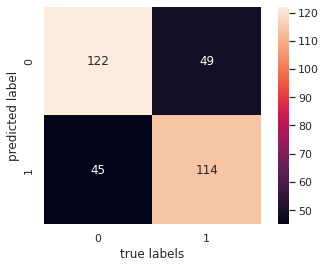

The accuracy is 0.7151515151515152
Scipy model on manual cost function


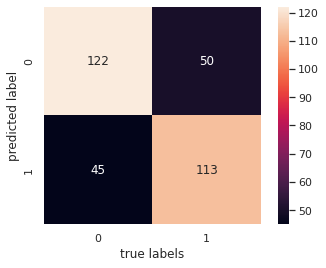

The accuracy is 0.7121212121212122
Sklearn Model


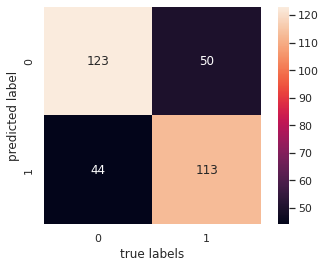

The accuracy is 0.7151515151515152


In [ ]:
print("Manual NewtonRaphson algorithm")
plot_confusion_matrix(Y_predict_nr, y_test)

print("Scipy model on manual cost function")
plot_confusion_matrix(Y_predict_scipy, y_test)

print("Sklearn Model")
plot_confusion_matrix(Y_predict_skl, y_test)